Raw shape: (179037, 120)
   0         1       2       3       4         5         6         7    \
0    0   20000.0 -9.2149  1.6078  4.1023  0.008918  0.005707  0.015156   
1    0   40000.0 -8.6113  1.5618  3.7249  0.024428 -0.002711 -0.020531   
2    0   60000.0 -8.8804  2.2894  3.8992  0.005306 -0.023138  0.029458   
3    0   80000.0 -8.9027  1.5766  3.9779 -0.002000 -0.013688 -0.013656   
4    0  100000.0 -8.7353  1.6078  3.8605  0.003471 -0.015327 -0.023457   

      8         9    ...       110       111      112      113      114  \
0  1.2476 -0.034121  ...  0.005075 -0.004637  0.77288  0.18375 -0.12589   
1  1.2498 -0.025369  ...  0.006886 -0.004596  0.77179  0.18946 -0.13054   
2  1.2509 -0.025673  ...  0.003375 -0.011827  0.77207  0.18821 -0.12990   
3  1.2469 -0.032399  ...  0.003363 -0.008280  0.77369  0.18514 -0.12733   
4  1.2469 -0.031557  ...  0.003186  0.006253  0.77369  0.18540 -0.12640   

        115      116      117      118  119  
0  0.079751  0.68380  0.19458 -0.

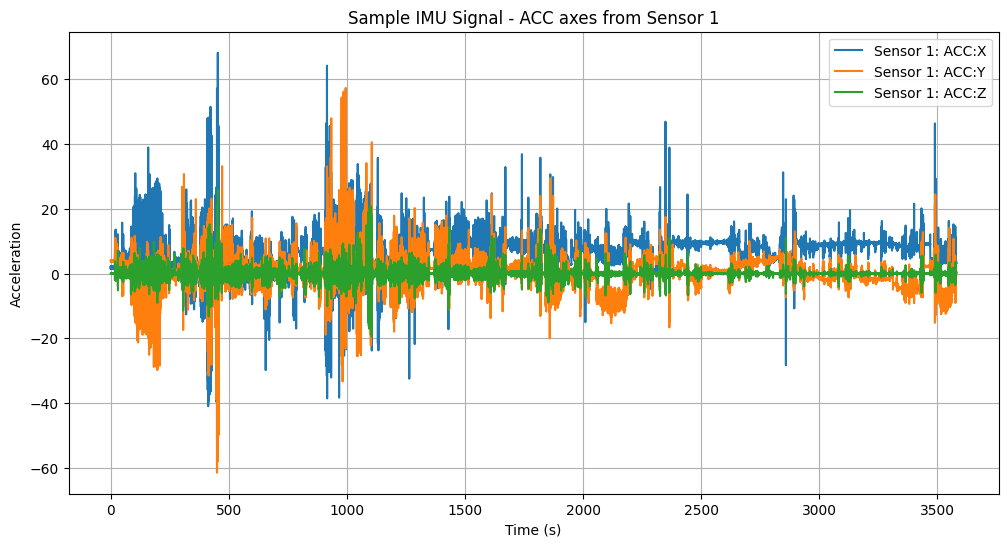

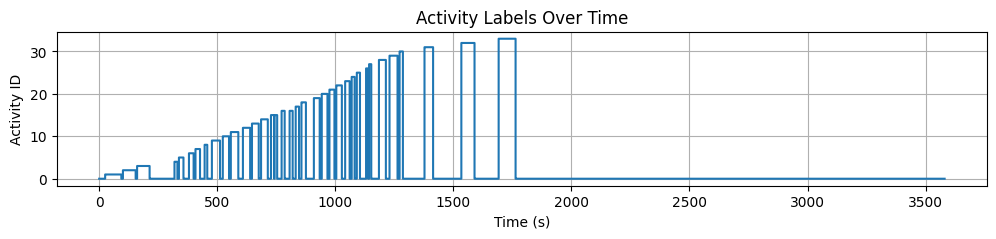

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Step 1: Load a .log file ===
log_file = '../data/Real_data/subject1_ideal.log'  # adjust filename if needed
df = pd.read_csv(log_file, sep='\t', header=None)

print("Raw shape:", df.shape)
print(df.head())

# === Step 2: Drop timestamps ===
df_clean = df.drop(columns=0)

# === Step 3: Separate features and labels ===
feature_cols = df_clean.columns[2:119]
label_col = 119

X = df_clean[feature_cols].astype(float)
y = df_clean[label_col].astype(int)


# === Step 4: Visualize a few sensor channels ===
time_axis = np.arange(len(X)) / 50.0  # since sampling rate is 50 Hz

plt.figure(figsize=(12, 6))
plt.plot(time_axis, X.iloc[:, 0], label='Sensor 1: ACC:X')
plt.plot(time_axis, X.iloc[:, 1], label='Sensor 1: ACC:Y')
plt.plot(time_axis, X.iloc[:, 2], label='Sensor 1: ACC:Z')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.title("Sample IMU Signal - ACC axes from Sensor 1")
plt.legend()
plt.grid(True)
plt.show()

# === Step 5: Plot activity label timeline ===
plt.figure(figsize=(12, 2))
plt.plot(time_axis, y, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Activity ID")
plt.title("Activity Labels Over Time")
plt.grid(True)
plt.show()


In [22]:
# === Step 6: Segment IMU data into labeled windows ===

window_size = 100  # 2 seconds at 50 Hz
step_size = 50     # 50% overlap
X_windows = []
y_labels = []

import glob

# === Step 1: Collect all log files ===
log_files = glob.glob("../data/Real_data/subject*.log")  # adjust extension if needed
print(f"Found {len(log_files)} log files.")

X_windows = []
y_labels = []

for log_file in log_files:
    try:
        df = pd.read_csv(log_file, sep='\t', header=None)
        df_clean = df.iloc[:, 2:-1]  # sensor features (cols 2 to 118)
        labels = df.iloc[:, -1]     # activity labels

        for start in range(0, len(df_clean) - window_size + 1, step_size):
            end = start + window_size
            window = df_clean.iloc[start:end].values
            label_window = labels[start:end]

            # Majority label filter
            majority_label = label_window.mode()[0]
            if majority_label == 0:
                continue

            X_windows.append(window)
            y_labels.append(majority_label)

    except Exception as e:
        print(f"Error processing {log_file}: {e}")

X_windows = np.array(X_windows)
y_labels = np.array(y_labels)

print(f"✅ Total labeled windows: {len(X_windows)}")
print(f"Shape: {X_windows.shape}, Labels: {y_labels.shape}")


print(f"Total windows extracted: {len(X_windows)}")
print(f"Shape of X_windows: {X_windows.shape}")
print(f"Shape of y_labels: {y_labels.shape}")


Found 46 log files.
✅ Total labeled windows: 40812
Shape: (40812, 100, 117), Labels: (40812,)
Total windows extracted: 40812
Shape of X_windows: (40812, 100, 117)
Shape of y_labels: (40812,)


In [21]:
import os
from scipy.signal import spectrogram
from PIL import Image, ImageOps
import csv

# Create output folder
output_dir = "../data/real_spectrograms"
os.makedirs(output_dir, exist_ok=True)

label_csv_path = "../data/real_labels.csv"
csv_rows = []

# Choose 3 channels: e.g. ACC:X, GYR:Y, GYR:Z
channel_indices = [0, 10, 20]  # adjust as needed (0=ACC:X, 10=GYR:Y, etc.)

for i, window in enumerate(X_windows):
    channels = []
    for ch in channel_indices:
        f, t, Sxx = spectrogram(window[:, ch], fs=50, nperseg=32, noverlap=16)
        Sxx = np.log(Sxx + 1e-10)  # log scale
        Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min()) * 255
        channels.append(Sxx.astype(np.uint8))

    # Resize to same shape and stack
    img_shape = np.min([c.shape for c in channels], axis=0)
    stacked = np.stack([c[:img_shape[0], :img_shape[1]] for c in channels], axis=-1)

    # Save as image
    filename = f"real_{i}.png"
    img = Image.fromarray(stacked)
    img = ImageOps.fit(img, (128, 128), Image.Resampling.BICUBIC)  # resize to 128x128
    img.save(os.path.join(output_dir, filename))

# Write labels.csv
with open(label_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "label"])
    writer.writerows(csv_rows)

print(f"Saved {len(csv_rows)} spectrograms to {output_dir}")
print(f"Labels written to {label_csv_path}")


C:\Users\smith\AppData\Local\Temp\ipykernel_43676\2922634674.py:21: RuntimeWarning: invalid value encountered in divide
  Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min()) * 255
C:\Users\smith\AppData\Local\Temp\ipykernel_43676\2922634674.py:22: RuntimeWarning: invalid value encountered in cast
  channels.append(Sxx.astype(np.uint8))


Saved 0 spectrograms to ../data/real_spectrograms
Labels written to ../data/real_labels.csv
